# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [1]:
##################### GENERAL IMPORTS #####################

import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

In [2]:
################## LOVE DETERMINISM ##################

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

In [3]:
################ ENV EXPERIMENTS (CARTPOLE) ################

env = gym.make('CartPole-v1')

env.reset()
print(type(env))
print(type(env.observation_space))
#[cart_position, cart_velocity, pole_angle, pole_angular_velocity]
#low bound [-4.8, -inf, -0.418, -inf]
#high bound [4.8, inf, 0.418, inf]
print(env.observation_space.shape)
print(env.observation_space.low) 
print(env.observation_space.high)

<class 'gymnasium.wrappers.common.TimeLimit'>
<class 'gymnasium.spaces.box.Box'>
(4,)
[-4.8               -inf -0.41887903        -inf]
[4.8               inf 0.41887903        inf]


**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

In [4]:
################### SOME HYPERPARAMETERS ###################

data_dir = './data'
checkpoints_dir = './checkpoints'
log_dir = './logs'

n_episodes = 250 #1000
lr = 1e-2
lr_s_factor = 0.5
eene = 10
ee = 10
hidden_w = 128
n_hidden_layers = 1
patience = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
############## TENSORBOARD VISUALIZATION ################

%load_ext tensorboard
%tensorboard --logdir=./logs

Launching TensorBoard...

In [ ]:
################ CLEARING STUFF ################

import shutil
import os

def clear(_dir):
    if os.path.exists(_dir):
        if os.path.isdir(_dir):
            shutil.rmtree(_dir)
        os.makedirs(_dir, exist_ok = True)

#clear(data_dir)
#clear(checkpoints_dir)
#clear(log_dir)

In [6]:
############### IMPORTING MY STUFF ###################

from RLTrainingPipeline import RLTrainingPipeline
from QLTrainingPipeline import QLTrainingPipeline
from MLP import MLP

In [8]:
############### DEFINE A POLICY ##################

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    #act_funcs = [nn.ReLU] * (n_hidden_layers) + [nn.Softmax], #depending on how select_action function is set up, in our case takes logits instead of probs
    #act_funcs_params = [dict() for _ in range(n_hidden_layers)] + [dict(dim = -1)],
    use_bias = [False, False] #quoting karpathy blogpost: "We’re not using biases because meh"
)

print(policy.blocks)

optimizer = optim.Adam(policy.parameters(), lr = lr)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene) #the metric we are monitoring does not change every step as lr_scheduling

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=False)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=False)
  )
)


**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

100%|██████████| 250/250 [00:36<00:00,  6.81it/s]


training time: 36.74s


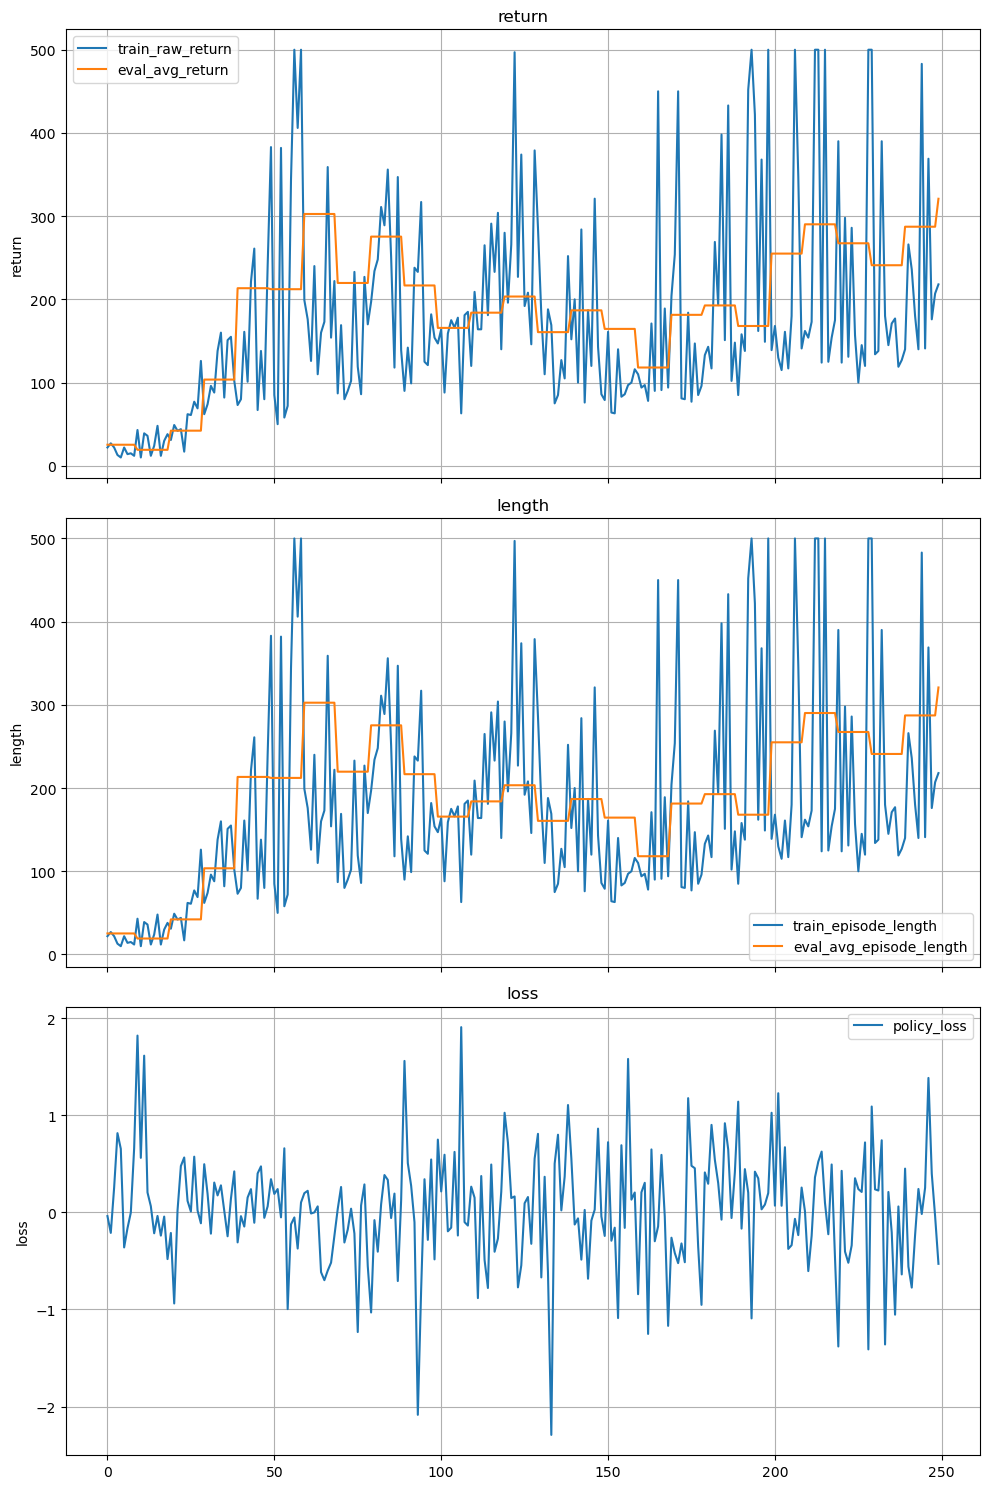

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>], dtype=object))

In [9]:
############### TEST THE POLICY ##################

env.reset()

pipeline = RLTrainingPipeline(
    policy,
    optimizer = optimizer,
    #lr_scheduler = scheduler,
    device = device,
    run_id = "first_test",
    log_dir = log_dir
)

history = pipeline.reinforce(
    env = env,
    n_episodes = n_episodes,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = ee
)

pipeline.plot()

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



In [10]:
############### REDEFINE A POLICY ##################

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    use_bias = [False, False] #quoting karpathy blogpost: "We’re not using biases because meh"
)

print(policy.blocks)

optimizer = optim.Adam(policy.parameters(), lr = lr)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene)

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=False)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=False)
  )
)


**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [11]:
############### STANDARDIZED BASELINE ##################

def std_baseline(returns, obss):
    dist = returns - returns.mean()
    return dist / dist.std()    

100%|██████████| 250/250 [01:15<00:00,  3.31it/s]


training time: 75.52s


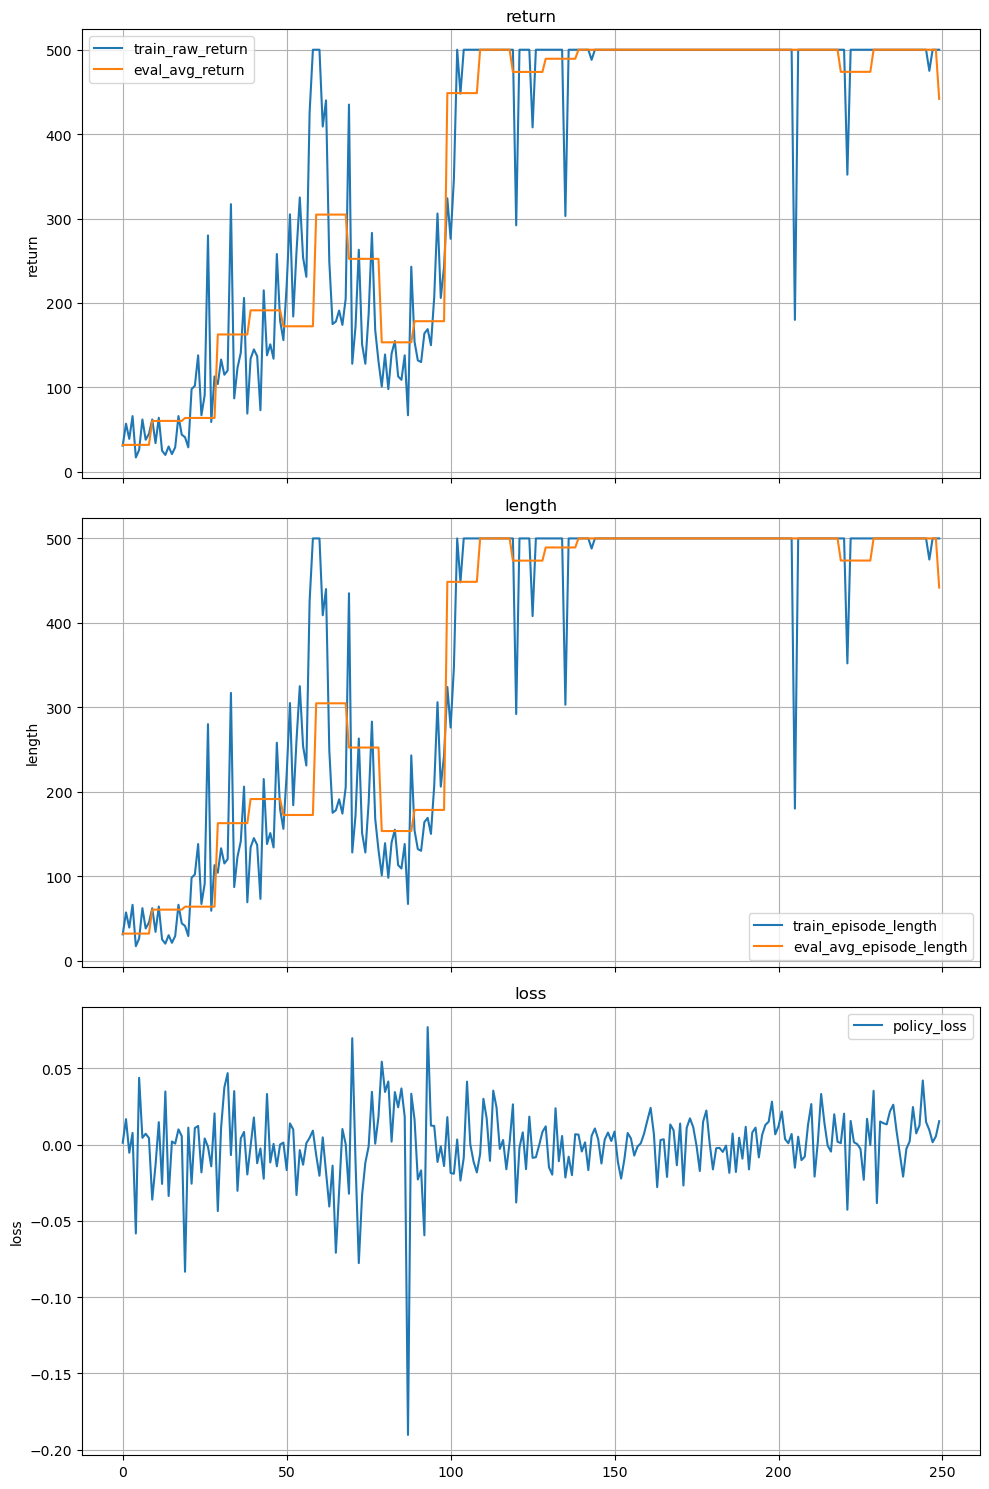

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>], dtype=object))

In [12]:
########## TEST THE POLICY WITH STD BASELINE ##########

env.reset()

pipeline = RLTrainingPipeline(
    policy,
    optimizer = optimizer,
    #lr_scheduler = scheduler,
    device = device,
    run_id = "second_test",
    log_dir = log_dir
)

history = pipeline.reinforce(
    env = env,
    n_episodes = n_episodes,
    baseline = std_baseline,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = ee
)

pipeline.plot()

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [13]:
########## VALUE BASELINE CLASS ##########

class ValueBaseline:
    def __init__(self, network, criterion, optimizer, lr_scheduler = None, device='cpu'):
        self.network      = network
        self.criterion    = criterion
        self.optimizer    = optimizer
        self.lr_scheduler = lr_scheduler
        self.device       = torch.device(device)
        
        self.network.to(self.device)
        if hasattr(self.criterion, "to"):
            self.criterion.to(self.device)
    
    def get_advantages(self, returns, obss):
        #move returns to device and ensure it's a tensor
        if not torch.is_tensor(returns):
            returns = torch.tensor(returns, dtype=torch.float32)
        returns = returns.to(self.device)          
        
        obs_batch = torch.stack([o.to(self.device) for o in obss]) 
        
        preds = self.network(obs_batch)
        
        if preds.ndim == 2 and preds.shape[1] == 1: preds = preds.squeeze(-1)

        assert preds.shape == returns.shape, f"preds {preds.shape} vs returns {returns.shape}"
        
        loss = self.criterion(preds, returns)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.lr_scheduler:
            self.lr_scheduler.step(loss.item())
        
        return returns - preds.detach()       


In [14]:
########## DEFINE A NETWORK AS BASELINE ##########

value = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [1],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    use_bias = [True, False]
)
print(value.blocks)

value_optimizer = optim.Adam(value.parameters(), lr = lr)

criterion = nn.MSELoss()

#value_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(value_optimizer, mode = 'min', factor = 0.35, patience = 12)

baseline = ValueBaseline(value, criterion, value_optimizer, device = device) 
#baseline = ValueBaseline(value, criterion, value_optimizer, lr_scheduler = value_lr_scheduler, device = device)

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=False)
  )
)


In [15]:
############### REDEFINE A POLICY ##################

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    use_bias = [False, False]
)

optimizer = optim.Adam(policy.parameters(), lr = lr)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene)

100%|██████████| 250/250 [01:36<00:00,  2.60it/s]


training time: 96.13s


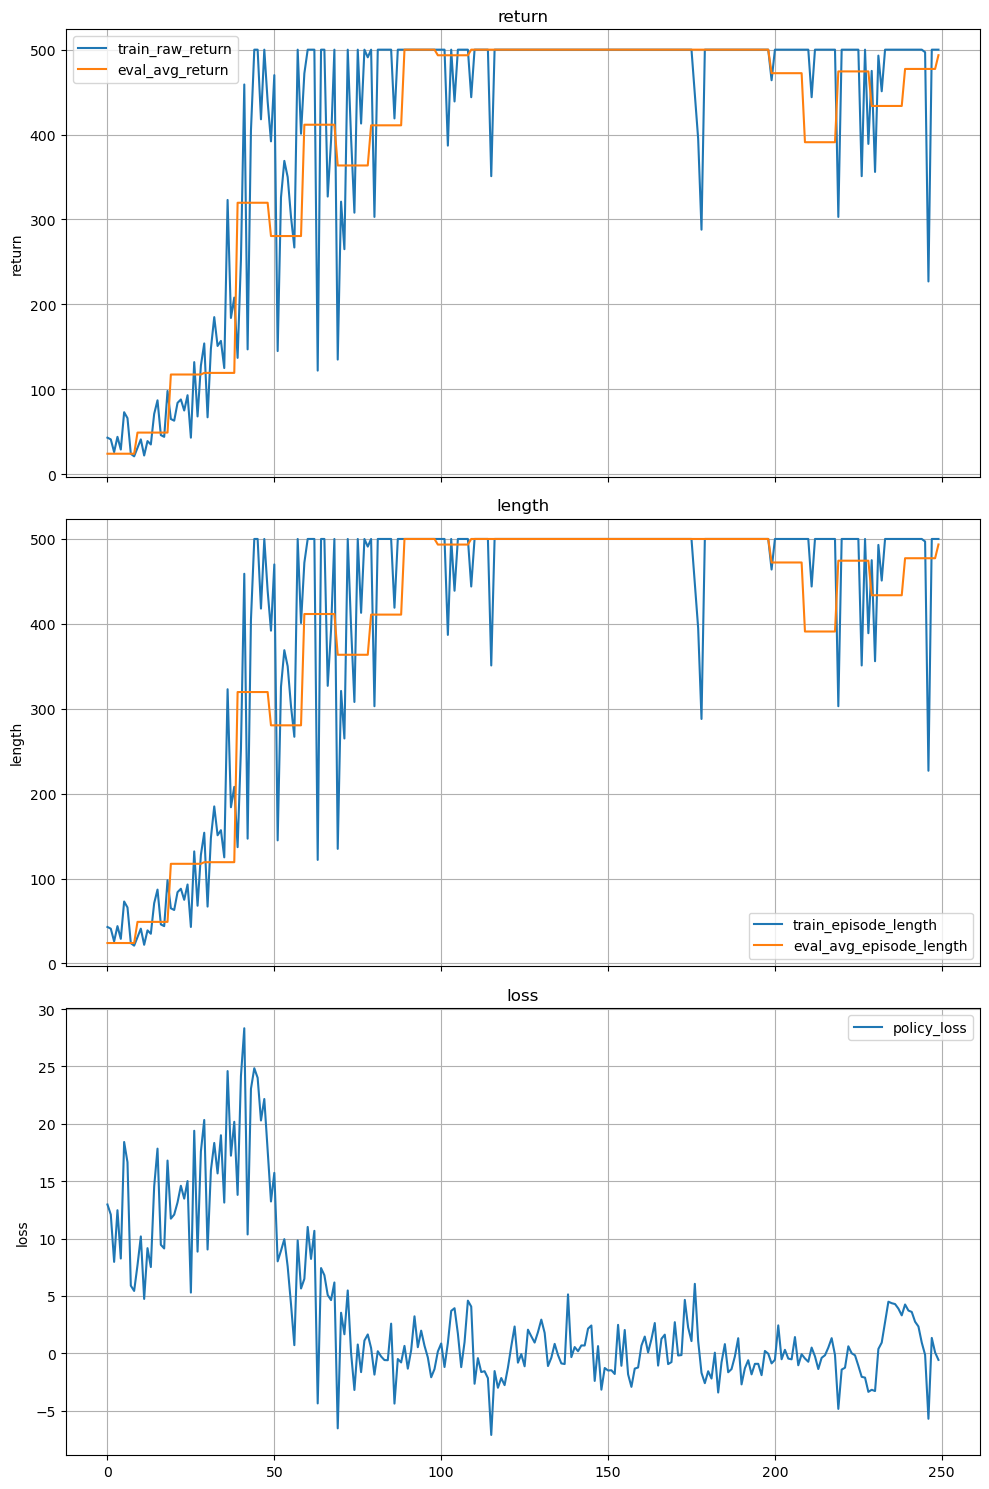

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>], dtype=object))

In [16]:
######## TEST A POLICY WITH NETWORK AS BASELINE ########

env.reset()

pipeline = RLTrainingPipeline(
    policy,
    optimizer = optimizer,
    #lr_scheduler = scheduler,
    device = device,
    run_id = "third_test",
    log_dir = log_dir,
)

history = pipeline.reinforce(
    env = env,
    n_episodes = n_episodes,
    baseline = baseline.get_advantages,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = ee
)

pipeline.plot()

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.


In [7]:
################ ENV EXPERIMENTS (LUNAR LANDER) ################

g = 9.80492 #(in florence)
enable_wind = False
wind_power = 7.5 #how is it?
turbulance_power = 1.5
env = gym.make("LunarLander-v3", 
                continuous = False, 
                gravity = - g, 
                enable_wind = enable_wind, 
                wind_power = wind_power, 
                turbulence_power = turbulance_power)

env.reset()
print(type(env))
print(type(env.observation_space))
# [x, y, vx, vy, angle, angular_vel, left_leg_touching_ground, right_leg_touching_ground]
print(env.observation_space.shape)
print(env.observation_space.low) 
print(env.observation_space.high)

<class 'gymnasium.wrappers.common.TimeLimit'>
<class 'gymnasium.spaces.box.Box'>
(8,)
[ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ]
[ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ]


In [8]:
###### CHANGE SOME HYPERPARAMETERS ACCORDING TO NEW ENV ######

n_episodes = 2500
maxlen = 1000
lr = 0.001
lr_s_factor = 0.75
eene = 20
patience = 10
n_hidden_layers = 2

In [19]:
########## DEFINE A NETWORK AS BASELINE ##########

value = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [1],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    use_bias = [True, False]
)

value_optimizer = optim.Adam(value.parameters(), lr = lr)

criterion = nn.MSELoss()

#value_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(value_optimizer, mode = 'min', factor = 0.35, patience = 12)

baseline = ValueBaseline(value, criterion, value_optimizer, device = device) 
#baseline = ValueBaseline(value, criterion, value_optimizer, lr_scheduler = value_lr_scheduler, device = device)

In [20]:
############### REDEFINE A POLICY ##################

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    #act_funcs = [nn.ReLU] * (n_hidden_layers) + [nn.Softmax],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    #act_funcs_params = [dict() for _ in range(n_hidden_layers)] + [dict(dim = -1)],
    use_bias = [False, False]
)

optimizer = optim.Adam(policy.parameters(), lr = lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene)

In [13]:
########### DEFINE A CALLBACK TO RENDER IMPROV ###########

import time
import pygame
from pygame.locals import K_ESCAPE

def render(env, policy, n_try = -1):
    env = env.unwrapped
    rendering = gym.make("LunarLander-v3", 
                        continuous = False, 
                        gravity = env.gravity, 
                        enable_wind = env.enable_wind, 
                        wind_power = env.wind_power, 
                        turbulence_power = env.turbulence_power,
                        render_mode = 'human')

    interrupted = False

    def check_for_escape():
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN and event.key == K_ESCAPE:
                return True
        return False

    try:
        while n_try != 0: #if n_try = -1 can be stopped only by user
            obs, info = rendering.reset()
            done = False
            while not done:
                #ESC to quit
                if check_for_escape():
                    raise KeyboardInterrupt

                obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                with torch.no_grad():
                    logits = policy(obs_tensor)
                    action = torch.argmax(logits, dim=-1).item()

                obs, reward, term, trunc, info = rendering.step(action)
                done = term or trunc
                rendering.render()
                time.sleep(1 / 60)
            n_try -= 1
    except KeyboardInterrupt:
        interrupted = True
    finally:
        rendering.close()
        return interrupted

def render_callback(pipeline, **context):
    eval_every_n_episodes = context.get("eval_every_n_episodes")
    episode = pipeline.current_episode
    n_episodes = context.get("n_episodes")
    env = context.get("env")

    if pipeline.callbacks_data.get("stop_rendering", False):
        return

    if  eval_every_n_episodes is None or \
        ((episode + 1) % eval_every_n_episodes != 0 and episode != n_episodes - 1):
        return

    interrupted = render(env = env, policy = pipeline.policy, n_try = 1)
    if interrupted:
        pipeline.callbacks_data["stop_rendering"] = True

callbacks = {"on_val_end": [render_callback]}

100%|██████████| 2500/2500 [22:52<00:00,  1.82it/s]


training time: 1372.94s


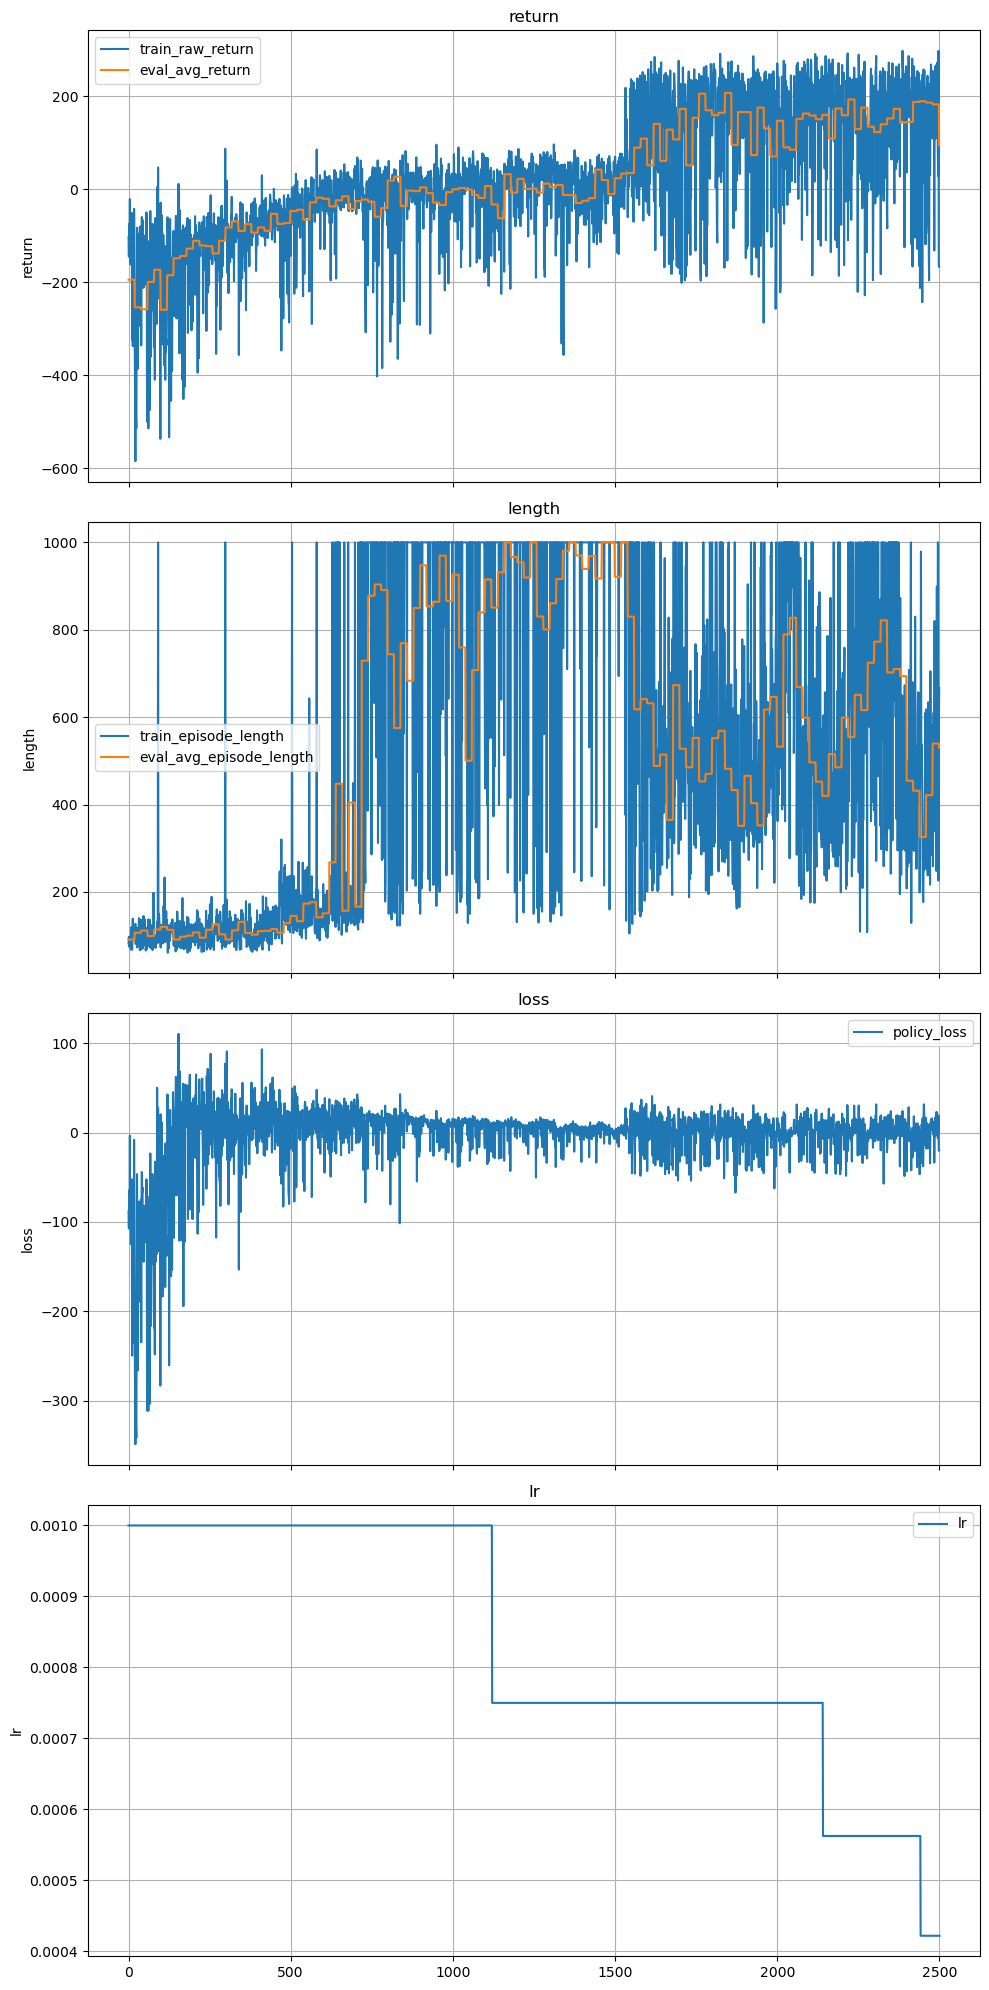

(<Figure size 1000x2000 with 4 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [22]:
######## TEST A POLICY WITH NETWORK AS BASELINE ########

env.reset()

pipeline = RLTrainingPipeline(
    policy,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    device = device,
    run_id = "lunar_landing",
    log_dir = log_dir,
    callbacks = callbacks
)

history = pipeline.reinforce(
    env = env,
    n_episodes = n_episodes,
    maxlen = maxlen,
    baseline = baseline.get_advantages,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = ee
)

pipeline.plot()

In [25]:
render(env, policy)

True


### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.



In [19]:
############### REDEFINE A POLICY ##################

lr = 1e-4 
n_hidden_layers = 3
hidden_w = 128
#patience = 13
eene = 20

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
)

optimizer = optim.AdamW(policy.parameters(), lr = lr)

#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene)

100%|██████████| 1500/1500 [16:56<00:00,  1.48it/s] 


training time: 1016.15s


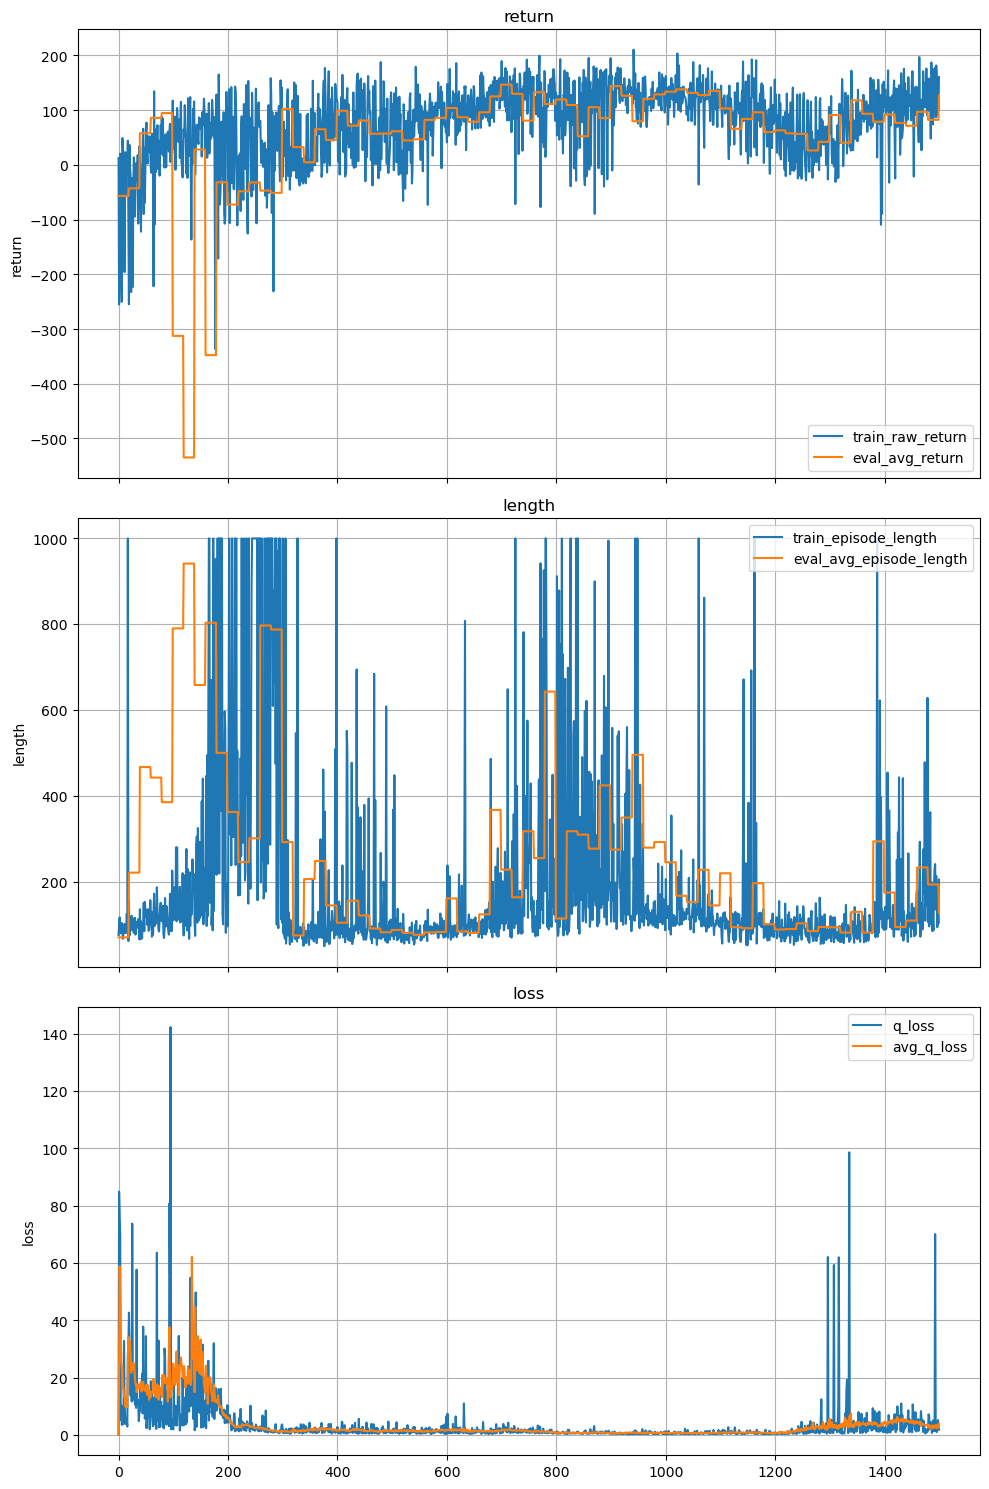

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>], dtype=object))

In [20]:
######## TEST A POLICY WITH Q-LEARNING ########

env.reset()

pipeline = QLTrainingPipeline(
    policy,
    optimizer = optimizer,
    device = device,
    #lr_scheduler = lr_scheduler,
    run_id = "lunar_landing_q",
    log_dir = log_dir,
    buffer_size = 10_000
)

history = pipeline.dqn(
    env = env,
    n_episodes = 1500,
    maxlen = 1000,
    batch_size = 128,
    gamma = 0.99,
    eps_decay = 0.995,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = 10,
    target_update_frequency = 7
)

pipeline.plot()

In [21]:
render(env, policy)

True

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 